# Create Beautiful AI Dashboards on a Shoestring with Python

<table><tr>
<td> <img src="img/logo_plotly.png" alt="Drawing" style="width: 50%;padding: 10px;"/> </td>
<td> <img src="img/logo_prophet.png" alt="Drawing" style="width: 50%;padding: 10px"/> </td>
<td> <img src="img/logo_panel.png" alt="Drawing" style="width: 50%;padding: 10px"/> </td>
</tr></table>

## Introduction
Reading online blog posts can give the impression that a company needs an army of data analysts and scientists working on the latest and greatest infrastructure to gain any value from their data. But in reality, a single resourceful data scientist equipped with a laptop and some data, can often reveal the most valuable insights.

In this blog post, we will show you how to build [this interactive, time-series forecasting dashboard](https://dataaccelerators.com/panel_dashboards/forecast.html) using only free, open-source Python packages. This dashboard can be shared with anyone who has a web browser – all without costly databases, analytics platforms, or servers!


<p>
Our dashboard visualises historical sales for a fictional company and uses a statistical forecasting model to generate a dynamic forecast of future sales using three great packages: Plotly for interactive visualisation, Prophet for forecasting and Panel for dashboarding.
</p>

## Visualise our historical data with Plotly

Let’s start by visualising our monthly sales data using Plotly. Plotly lets us create beautiful visualisations that users can interact with; a helpful tooltip appears when you hover over a data point, clicking and dragging allows you to zoom the chart in on an interesting time window.

First we install and load the Python packages needed to build our dashboard

In [ ]:
!pip install -r requirements.txt

In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from plotly.graph_objs._figure import Figure
from typing import Optional

Now, let's load our sales data.

In [5]:
df = pd.read_csv("./sales.csv", parse_dates=["Month"], dtype={"Sales": float})
df.head()

,Month,Sales
0,2014-01-01,19650.09
1,2014-02-01,26184.90
2,2014-03-01,36078.76
3,2014-04-01,43185.21
4,2014-05-01,43761.61


Let's create a function that will plot our sales data for us using Plotly.

In [3]:
def plot_historical_sales(
    df: pd.DataFrame, outliers: Optional[list] = None
) -> Figure:
    """
    Create an interactive line graph from timeseries data

    Parameters
    ----------
    df: dataframe containing two columns: Month and Sales
    outliers: optional list of strings representing outlier dates, e.g. ("2021-08-01, "2021-09-03")

    Returns
    ------
    Plotly figure
    """
    # Copy the data so that we don't modify the original
    df = df.copy(deep=True)

    # Plot line
    fig = px.line(
        df,
        x="Month",
        y="Sales",
        markers=False,
    ).update_layout(yaxis_range=[0, 90_000])

    # Prepare markers, with outliers coloured red 
    df["colour"] = "#636efa"
    if outliers is not None:
        df.loc[df["Month"].isin(outliers), "colour"] = "red"
        
    fig.add_traces(
        list(
            px.scatter(
                df,
                x="Month",
                y="Sales",
                color="colour",
                hover_data={"colour": False},
            ).select_traces()
        )
    )

    # Insert some space between the yaxis tick labels and axis
    fig = fig.update_yaxes(ticksuffix=" ")

    # Move legend and modify y-axis title
    fig.update_layout(
        showlegend=False, 
        yaxis_title="Sales (€)",
        margin=dict(l=20, r=20, t=30, b=20),
    )

    # Format the tooltip
    fig.update_traces(
        hovertemplate="<br>".join(
            ["Month = %{x|%b %Y}", "Sales = €%{y:.2s}", "<extra></extra>"]
        ),
    )

    return fig

In [21]:
# Use our new function to plot the monthly sales data, highlighting outliers
fig = plot_historical_sales(
    df, outliers=["2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01"]
)
fig

We can see that our turnover is characterised by 
- a pattern of **yearly seasonality**, with sales peaking between March and May, with a smaller peak in October and November
- a **long-term trend**, with sales approximately doubling across the period
- and a series of four **outliers** months from March to June of 2020, marked by unusually low turnover. 

## Develop our forecast with Prophet
Let's use what we have learned to develop a statistical model that captures the patterns and trends in our data, enabling it to accurately forecast future sales. We will use, Prophet, a package developed by Facebook for forecasting time-series, by combining relatively intuitive components.

In [5]:
from prophet import Prophet

We create a function that takes our time-series of historical sales and a set of assumptions about the time-series and provides us with a trained statistical model.

In [6]:
def fit_sales_model(
    df,
    linear_trend: Optional[bool] = True,
    show_outliers: Optional[bool] = True,
    yearly_seasonality: Optional[bool] = True,
    weekly_seasonality: Optional[bool] = False,
    daily_seasonality: Optional[bool] = False,
    seasonality_mode: Optional[str] = "multiplicative",
    **kwargs
):
    """
    Fits a Prophet model to our sales timeseries

    Parameters
    ----------
    df: Dataframe containing two columns: Month and Sales
    linear_trend: Controls whether the model includes a linear trend
    show_outliers: Controls whether outliers are excluded from model
    yearly_seasonality: Fit yearly seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    weekly_seasonality: Fit weekly seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    daily_seasonality: Fit daily seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    seasonality_mode: 'additive' or 'multiplicative' (default).

    Returns
    ------
    Fitted Prophet model.
    """

    # Create dictionary to hold the model parameters
    model_params = {
        "yearly_seasonality": yearly_seasonality,
        "weekly_seasonality": weekly_seasonality,
        "daily_seasonality": daily_seasonality,
        "seasonality_mode": seasonality_mode,
    }
    if linear_trend:
        model_params["growth"] = "linear"
    else:
        model_params["growth"] = "flat"


    # Prepare data used for model fitting
    df = df.copy(deep=True)

    # Rename the columns to what Prophet expects
    df = df.rename(columns={"Month": "ds", "Sales": "y"})

    # Remove outliers, if specified
    if show_outliers:
        outliers = ("2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01")
        df.loc[df["ds"].isin(outliers), "y"] = np.nan        

    # Check that we have only one row per date
    assert df["ds"].is_unique

    # Define the model structure
    m = Prophet(**model_params)

    # Fit model
    m.fit(df, **kwargs)

    return m

In [22]:
m = fit_sales_model(df)

23:13:31 - cmdstanpy - INFO - Chain [1] start processing
23:13:31 - cmdstanpy - INFO - Chain [1] done processing


Now let's use our fitted statistical model to generate a forecast. 

In [8]:
from typing import Optional, Union
from datetime import datetime
from pandas.tseries.offsets import DateOffset

In [9]:
def generate_predictions(
    m: Prophet,
    start: Optional[Union[str, datetime]] = None,
    end: Optional[Union[str, datetime]] = None,
    periods: Optional[int] = None, 
    freq: Optional[Union[str, DateOffset]] = None
) -> pd.DataFrame:
    """
    Generate a forecast using fitted Prophet model

    Parameters
    ----------
    m: a fitted Prophet model
    start : str or datetime-like, optional
        Left bound for generating forecast dates.
    end : str or datetime-like, optional
        Right bound for generating forecast dates.
    periods : int, optional
        Number of forecast periods to generate.
    freq : str or DateOffset, default 'D'
        Frequency strings can have multiples, e.g. '5H'. See
        :ref:`here <timeseries.offset_aliases>` for a list of
        frequency aliases.

    Returns
    -------
    Dataframe containing forecast

    Notes
    -----
    Of the four parameters ``start``, ``end``, ``periods``, and ``freq``,
    exactly three must be specified. If ``freq`` is omitted, the resulting
    ``DatetimeIndex`` will have ``periods`` linearly spaced elements between
    ``start`` and ``end`` (closed on both sides).

    To learn more about the frequency strings, please see `this link
    <https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases>`__.
    """
    # Prepare dataframe of dates we want to forecast
    forecast_dates = pd.date_range(start=start, end=end, periods=periods, freq=freq)
    future = pd.DataFrame(forecast_dates, columns=["ds"])

    # Check that there are no duplicate dates
    assert future["ds"].is_unique

    # Generate predictions
    forecast = m.predict(future)

    return forecast

In [10]:
forecast = generate_predictions(m, start="2023-01-01", periods=5, freq="MS")
forecast.loc[:, ["ds", "yhat_lower", "yhat", "yhat_upper"]]

,ds,yhat_lower,yhat,yhat_upper
0,2023-01-01,37378.097155,42093.830489,46867.464563
1,2023-02-01,39267.932425,44275.761861,49434.959285
2,2023-03-01,60827.780975,65937.779121,70645.212855
3,2023-04-01,68832.443847,73796.828699,78591.154043
4,2023-05-01,76406.127853,81463.359935,86554.342068


Prophet has provided us with a dataframe containing our forecast. But it's a little hard to absorb. Let's create a new function that uses Plotly to visualise it for us.

In [11]:
def plot_sales_forecast(forecast: pd.DataFrame):
    """
    Generate a forecast using fitted Prophet model

    Parameters
    ----------
    m: a fitted Prophet model
    start : str or datetime-like, optional
        Left bound for generating forecast dates.
    end : str or datetime-like, optional
        Right bound for generating forecast dates.
    periods : int, optional
        Number of forecast periods to generate.
    freq : str or DateOffset, default 'D'
        Frequency strings can have multiples, e.g. '5H'. See
        :ref:`here <timeseries.offset_aliases>` for a list of
        frequency aliases.

    Returns
    -------
    Dataframe containing forecast

    Notes
    -----
    Of the four parameters ``start``, ``end``, ``periods``, and ``freq``,
    exactly three must be specified. If ``freq`` is omitted, the resulting
    ``DatetimeIndex`` will have ``periods`` linearly spaced elements between
    ``start`` and ``end`` (closed on both sides).

    To learn more about the frequency strings, please see `this link
    <https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases>`__.
    """
    # Formatting string for tooltip
    tooltip = "Month = %{x|%b %Y}<br>Sales = €%{y:.2s}"

    # Create a line chart with the average prediction,
    # adding the upper and lower bounds of the forecast's uncertainty
    fig = go.Figure(
        [
            go.Scatter(
                name="Upper Bound",
                x=forecast["ds"],
                y=forecast["yhat_upper"],
                mode="lines",
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False,
                hovertemplate=tooltip,
            ),
            go.Scatter(
                name="Lower Bound",
                x=forecast["ds"],
                y=forecast["yhat_lower"],
                marker=dict(color="#444"),
                line=dict(width=0),
                mode="lines",
                fillcolor="rgba(68, 68, 68, 0.3)",
                fill="tonexty",
                showlegend=False,
                hovertemplate=tooltip,
            ),
            go.Scatter(
                name="Prediction",
                x=forecast["ds"],
                y=forecast["yhat"],
                mode="lines+markers",
                line=dict(color="#636efa"),
                showlegend=False,
                hovertemplate=tooltip,
            ),
        ]
    )

    # Modify the y-axis limits and title
    (
        fig.update_layout(
            yaxis_range=[0, 90_000], 
            yaxis_title="Sales (€)",
            margin=dict(l=20, r=20, t=30, b=20),
        ).update_yaxes(showticklabels=True, showgrid=True)
    )

    # Insert some space between the yaxis tick labels and axis
    fig = fig.update_yaxes(ticksuffix=" ")

    # Force the x-axis to use monthly tick marks when we only have a small number of timepoints
    if len(forecast.index) <= 6:
        fig = fig.update_xaxes(
            tickformat="%b\n%Y", tickmode="array", tickvals=forecast["ds"].values
        )

    return fig

In [12]:
fig = plot_sales_forecast(forecast)
fig

## Gather our findings in a Panel dashboard
Now that we have loaded our data, developed our statistical model, and used it to generate a forecast, let's put it all together in a dashboard so that it can be shared with stakeholders.

Panel is a great dashboarding solution for anyone who likes to works in Jupyter Notebooks and is already familiar with visualisation packages like Plotly, Matplotlib, Seaborn, Bokeh. It gives you the freedom to build an interactive, responsive dashboard using Jupyter Notebook or a Python IDE. The dashboard can then be shared in multiple ways: by sharing the notebook, by hosting the dashboard on a server, or by exporting the dashboard as a HTML file allowing it to be shared with anyone with a browser.

In [20]:
from io import StringIO
import panel as pn
import param

pn.extension("plotly")

We start by creating a class that represents the chart and widget components of our dashboard, and the dependencies between them. This uses the visualisation and functions we have already created.

In [15]:
class Forecaster(param.Parameterized):

    df = param.DataFrame(precedence=-1)  # precedence <1, will not be shown as widget
    outliers = param.List(item_type=str, precedence=-1)
    forecast = param.DataFrame(precedence=-1)
    model = param.Parameter(precedence=-1)

    periods = param.Integer(default=12, bounds=(1, 36))
    toggle_seasonality = param.Boolean(default=True)
    toggle_trend = param.Boolean(default=True)
    toggle_outliers = param.Boolean(default=True)

    def __init__(self, df, outliers, **kwargs):
        super().__init__(**kwargs)
        self.df = df
        self.outliers = outliers
        self.fit_sales_model()
        self.generate_forecast()

    @param.depends("toggle_outliers")
    def plot_historical_sales(self):
        return plot_historical_sales(self.df, self.outliers)

    @param.depends(
        "toggle_outliers",
        "toggle_seasonality",
        "toggle_trend",
        watch=True,
    )
    def fit_sales_model(self):
        self.model = fit_sales_model(
            self.df,
            linear_trend=self.toggle_trend,
            show_outliers=self.toggle_outliers,
            yearly_seasonality=self.toggle_seasonality,
        )

    @param.depends("model", "periods", watch=True)
    def generate_forecast(self):
        self.forecast = generate_predictions(
            self.model,
            start=self.df["Month"].max() + pd.tseries.offsets.DateOffset(months=1),
            periods=self.periods,
            freq="MS",
        )

    @param.depends("forecast")
    def plot_sales_forecast(self):
        return plot_sales_forecast(self.forecast)

    def get_csv(self):
        """Convert our forecast dataframe to a csv file object"""
        sio = StringIO()
        (
            self.forecast.loc[:, ["ds", "yhat_lower", "yhat", "yhat_upper"]]
            .rename(
                columns={
                    "ds": "Month",
                    "yhat_lower": "Lower Bound",
                    "yhat": "Prediction",
                    "yhat_upper": "Upper Bound",
                }
            )
            .round(2)
            .to_csv(sio, index=False)
        )
        sio.seek(0)
        return sio


# Initialise an instance of the class
forecaster = Forecaster(
    df=df, 
    outliers=["2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01"]
)

23:00:17 - cmdstanpy - INFO - Chain [1] start processing
23:00:17 - cmdstanpy - INFO - Chain [1] done processing


Now we build the structure of our dashboard by assembling our plots, widgets and text using Panel's row and column containers.

In [16]:
# Let's define a couple of CSS class to center our text and flexbox elements
pn.extension(
    raw_css=[
        """
    .bk.panel-markdown-center {
      text-align: center
    }

    .bk.panel-flexbox-center {
      justify-content: space-around;
      align-items: stretch;
      gap: 500px
    }
    """
    ]
)


panel = pn.Column(
    pn.Row(
        pn.Spacer(width=100),
        pn.pane.Markdown(
            """
            # > Forecasting Made Simple
            <br/><br/>
            This simple app prepares a business forecast that can be shared, opened by
            anyone with a browser, customised and exported. 
            <br/><br/>
            It uses no servers, databases, or licenses! All you need are the four Ps:
            Python, [Prophet](https://facebook.github.io/prophet/) for time-series
            forecasting, [Plotly](https://plotly.com/) for data visualisation, and 
            [Panel](https://panel.holoviz.org/) for dashboarding. 
            """,
            max_width=600,
            sizing_mode="stretch_width",
        ),
        pn.Spacer(width=100),
        align="center",
        sizing_mode="stretch_width",
        css_classes=["panel-markdown-center"],
        margin=0,
    ),
    pn.Row(
        pn.pane.PNG(
            "./logo_prophet.png",
            link_url="https://facebook.github.io/prophet/",
            alt_text="Prophet",
            width=80,
            margin=(0, 25),
        ),
        pn.pane.PNG(
            "./logo_plotly.png",
            link_url="https://plotly.com/",
            alt_text="Plotly",
            width=80,
            margin=(0, 25),
        ),
        pn.pane.PNG(
            "./logo_panel.png",
            link_url="https://panel.holoviz.org/",
            alt_text="Panel",
            width=80,
            margin=(0, 25),
        ),
        align="center",
    ),
    pn.Row(
        pn.pane.Markdown(
            """
            <br/><br/><br/> 
            ## Historical data
            
            """,
        ),
        align="center",
        css_classes=["panel-markdown-center"],
    ),
    pn.FlexBox(
        pn.Column(
            forecaster.plot_historical_sales,
        ),
        pn.Column(
            pn.pane.Markdown(
                """
                We can see that our turnover is characterised by a pattern of **yearly
                seasonality**, an **increasing trend** across time and contains a
                couple of potentially misleading **outliers**. 
                <br/><br/>
                """,
                align="center",
            ),
            css_classes=["panel-markdown-center"],
        ),
        justify_content="space-around",
        align_items="center",
    ),
    pn.Row(
        pn.pane.Markdown(
            """
            ## Forecast

            Let's use Prophet and what we learned about our data to forecast our 
            turnover. 
            <br/><br/>
            Use the buttons below to see the effect of changing the assumptions
            that our forecast makes. When you're satisfied with the forecast, use 
            the download button below to export it.
            """,
            max_width=650,
            sizing_mode="stretch_width",
            css_classes=["panel-markdown-center"],
        ),
        align="center",
        sizing_mode="stretch_width",
    ),
    pn.FlexBox(
        pn.Column(
            pn.Param(
                forecaster.param.toggle_seasonality,
                widgets={"toggle_seasonality": pn.widgets.Toggle},
            ),
            pn.Param(
                forecaster.param.toggle_trend,
                widgets={"toggle_trend": pn.widgets.Toggle},
            ),
            pn.Param(
                forecaster.param.toggle_outliers,
                widgets={"toggle_outliers": pn.widgets.Toggle},
            ),
            forecaster.param.periods,
            align="center",
        ),
        pn.Column(pn.Row(forecaster.plot_sales_forecast, align="center")),
        justify_content="space-around",
        align_items="center",
    ),
    pn.widgets.FileDownload(
        filename="data.csv",
        callback=forecaster.get_csv,
        button_type="primary",
        label="Download",
        align="center",
        max_width=300,
        embed=True,
    ),
    sizing_mode="stretch_width",
)

Now we can render the dashboard right here in this notebook!

Column(sizing_mode='stretch_width')
    [0] Row(align='center', css_classes=['panel-markdown-center'], sizing_mode='stretch_width')
        [0] Spacer(width=100)
        [1] Markdown(str, max_width=600, sizing_mode='stretch_width')
        [2] Spacer(width=100)
    [1] Row(align='center')
        [0] PNG(str, alt_text='Prophet', link_url='https://facebook.github.i..., margin=(0, 25), width=80)
        [1] PNG(str, alt_text='Plotly', link_url='https://plotly.com/', margin=(0, 25), width=80)
        [2] PNG(str, alt_text='Panel', link_url='https://panel.holoviz.org..., margin=(0, 25), width=80)
    [2] Row(align='center', css_classes=['panel-markdown-center'])
        [0] Markdown(str)
    [3] FlexBox(align_items='center', justify_content='space-around', objects=[Column
    [0] ParamMetho...], sizing_mode='stretch_width')
    [4] Row(align='center', sizing_mode='stretch_width')
        [0] Markdown(str, css_classes=['panel-markdown-center'], max_width=650, sizing_mode='stretch_width')
    [5] FlexBox(align_items='center', justify_content='space-around', objects=[Column(align='center')
  ...], sizing_mode='stretch_width')
    [6] FileDownload(_transfers=1, align='center', button_type='primary', callback=<bound method Forecaster.g..., data='data:text/plain;charset=U..., embed=True, filename='data.csv', label='Download', max_width=300)
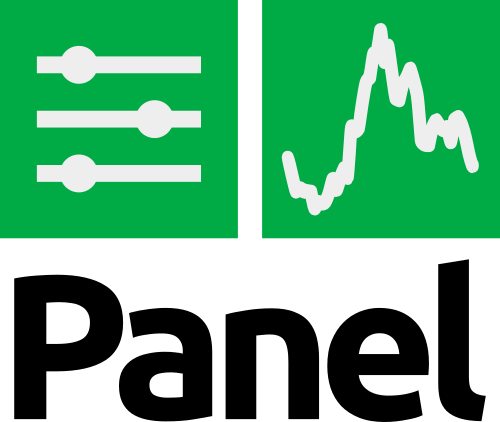
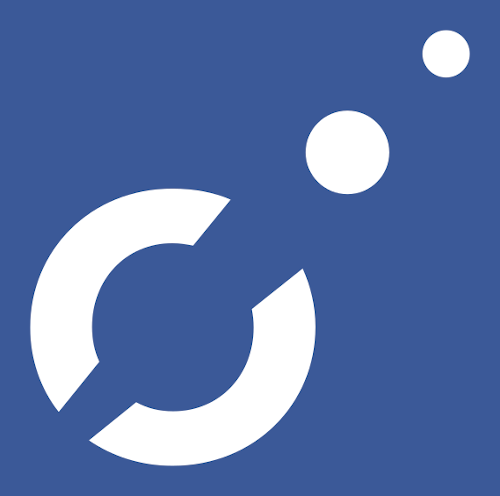
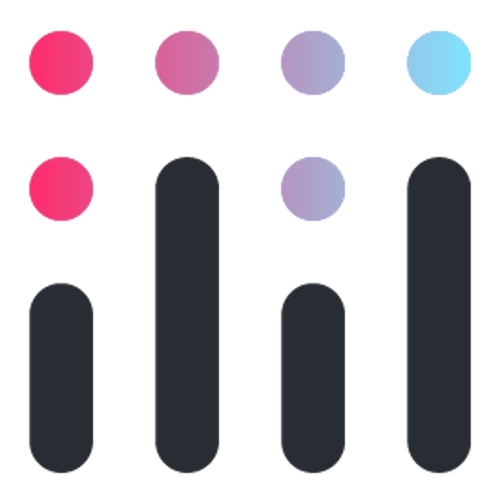

In [17]:
panel

## Share our dashboard as an HTML file

What if we want to share our dashboard with someone who doesn't have Python? No problem! Let's export the dashboard as a HTML file. 

In [18]:
from bokeh.resources import INLINE
import warnings

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)
    panel.save(
        "forecast.html",
        resources=INLINE,
        embed=True,
        embed_states={
            panel.select(lambda x: x.name == "Periods")[0]: [3, 6, 12, 24, 36],
            panel.select(lambda x: x.name == "Toggle trend")[0]: [True, False],
            panel.select(lambda x: x.name == "Toggle seasonality")[0]: [True, False],
            panel.select(lambda x: x.name == "Toggle outliers")[0]: [True, False],
        },
        progress=False,
    )

!open forecast.html

23:00:36 - cmdstanpy - INFO - Chain [1] start processing
23:00:36 - cmdstanpy - INFO - Chain [1] done processing
23:00:45 - cmdstanpy - INFO - Chain [1] start processing
23:00:45 - cmdstanpy - INFO - Chain [1] done processing
23:00:46 - cmdstanpy - INFO - Chain [1] start processing
23:00:46 - cmdstanpy - INFO - Chain [1] done processing
23:00:53 - cmdstanpy - INFO - Chain [1] start processing
23:00:53 - cmdstanpy - INFO - Chain [1] done processing
23:00:59 - cmdstanpy - INFO - Chain [1] start processing
23:00:59 - cmdstanpy - INFO - Chain [1] done processing
23:01:01 - cmdstanpy - INFO - Chain [1] start processing
23:01:01 - cmdstanpy - INFO - Chain [1] done processing
23:01:02 - cmdstanpy - INFO - Chain [1] start processing
23:01:02 - cmdstanpy - INFO - Chain [1] done processing
23:01:08 - cmdstanpy - INFO - Chain [1] start processing
23:01:08 - cmdstanpy - INFO - Chain [1] done processing
23:01:15 - cmdstanpy - INFO - Chain [1] start processing
23:01:15 - cmdstanpy - INFO - Chain [1]

This generates a file, forecast.html, that can be shared by email and opened on any device with a web browser!

<div class="alert alert-info">
Panel also makes it easy to share your dashboard in other ways. It can also be shared by hosting it on a server, allowing your stakeholders to access it via a URL. This also allows you to control access and update the dashboard with new data automatically.
</div>

## Conclusion
We hope this gives you a glimpse of the value that data science and analytics can provide – before you invest your time and resources.